 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import xarray as xr

from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
results_dir = Path('/Users/sallen/Documents/MEOPAR/Results/08may18/')
ufile = 'SalishSea_1h_20180508_20180508_grid_U.nc'
vfile = 'SalishSea_1h_20180508_20180508_grid_V.nc'
meshfile = '/Users/sallen/Documents/MEOPAR/grid/mesh_mask.nc'
bathyfile = '/Users/sallen/Documents/MEOPAR/grid/bathymetry_201702.nc'

In [3]:
mesh = xr.open_dataset(meshfile)
latitude = mesh.gphit
longitude = mesh.glamt
lat = mesh.nav_lat
#print (longitude)
#print (lat)
print ((lat-latitude).max())

<xarray.DataArray ()>
array(0.0)


In [4]:
uds = xr.open_dataset(results_dir/ufile)
uupper = uds.vozocrtx.isel(depthu=slice(5)).where(
      mesh.umask.isel(z=slice(5)).rename({'z': 'depthu'})).mean('depthu')
ufull = uds.vozocrtx.isel(depthu=slice(10)).where(
      mesh.umask.isel(z=slice(10)).rename({'z': 'depthu'})).mean('depthu')
vds = xr.open_dataset(results_dir/vfile)
vupper = vds.vomecrty.isel(depthv=slice(5)).where(
      mesh.vmask.isel(z=slice(5)).rename({'z': 'depthv'})).mean('depthv')
vfull = vds.vomecrty.isel(depthv=slice(10)).where(
      mesh.vmask.isel(z=slice(10)).rename({'z': 'depthv'})).mean('depthv')

In [5]:
u5 = viz_tools.unstagger_xarray(uupper[:, :, :, 0], 'x')  # array starts at x=0, y=0 with NaN's so all good
v5 = viz_tools.unstagger_xarray(vupper[:, :, :, 0], 'y')  # array starts at x=0, y=0
u10 = viz_tools.unstagger_xarray(ufull[:, :, :, 0], 'x')
v10 = viz_tools.unstagger_xarray(vfull[:, :, :, 0], 'y')

In [6]:
urot5, vrot5 = viz_tools.rotate_vel(u5, v5, origin='grid')
urot10, vrot10 = viz_tools.rotate_vel(u10, v10, origin='grid')

In [7]:
print(urot5)

<xarray.DataArray (time_counter: 24, y: 898, x: 398)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]], dtype=float32)
Coordinates:
    time_centered  (time_counter) datetime64[ns] 2018-05-08T00:30:00 ...
  * time_counter   (time_counter) datetime64[ns] 2018-05-08T00:30:00 ...
Dimensions without coordinates: y, x


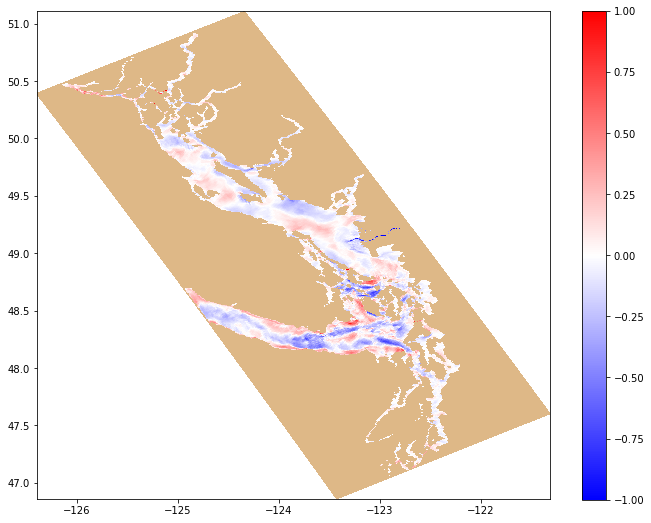

In [8]:
cmap = plt.get_cmap('bwr')
cmap.set_bad(color='burlywood')
fig, ax = plt.subplots(1, 1, figsize=(11.5, 9))
mesh = ax.pcolormesh(longitude[0], latitude[0], np.ma.masked_invalid(urot5[0]), cmap=cmap, vmax=1, vmin=-1)
viz_tools.set_aspect(ax)
fig.colorbar(mesh);

In [9]:
urot5.coords['x'] = range(398)
urot5.coords['y'] = range(898)

In [10]:
latitude = latitude.squeeze('t')
longitude = longitude.squeeze('t')

In [11]:
myds = xr.Dataset(data_vars={
    'VelEast5': urot5,
    'VelNorth5': vrot5,
    'VelEast10': urot10,
    'VelNorth10': vrot10,
    'latitude': latitude,
    'longitude': longitude}, coords=urot5.coords)
myds.VelEast5.attrs = {'long_name': 'Upper 5 grid levels East Velocity',
                       'standard_name' : 'eastward_sea_water_velocity_upper_5_grid_levels',
                       'ioos_category' : 'currents',
                       'comment' : 'Average velocity over the upper 5 grid levels, nominally 5 m',
                   'units': 'm/s'}
myds.VelNorth5.attrs = {'long_name': 'Upper 5 grid levels North Velocity',
                        'standard_name' : 'northward_sea_water_velocity_upper_5_grid_levels',
                        'ioos_category' : 'currents',
                        'comment' : 'Average velocity over the upper 5 grid levels, nominally 5 m',
                   'units': 'm/s'}
myds.VelEast10.attrs = {'long_name': 'Upper 10 grid levels East Velocity',
                        'standard_name' : 'eastward_sea_water_velocity_upper_10_grid_levels',
                        'ioos_category' : 'currents',
                        'comment' : 'Average velocity over the upper 10 grid levels, nominally 10 m',
                   'units': 'm/s'}
myds.VelNorth10.attrs = {'long_name': 'Upper 10 grid levels North Velocity',
                         'standard_name' : 'northward_sea_water_velocity_upper_10_grid_levels',
                         'ioos_category' : 'currents',
                         'comment' : 'Average velocity over the upper 10 grid levels, nominally 10 m',
                   'units': 'm/s'}

In [12]:
myds = myds.drop('time_centered')
myds = myds.rename({'time_counter': 'time', 'x': 'gridX', 'y': 'gridY'})

In [13]:
encoding = {'time': {'units': 'minutes since 1970-01-01 00:00'},
           'VelEast5': {'zlib': True, 'complevel': 4},
           'VelNorth5': {'zlib': True, 'complevel': 4},
            'VelEast10': {'zlib': True, 'complevel': 4},
           'VelNorth10': {'zlib': True, 'complevel': 4},
           }

In [14]:
myds.attrs = {'history': 'Test velocity data set, made by analysis-susan/notebooks/VelocityFiles/SlicedForCHS.ipynb'}

In [18]:
myds.coords['time'].attrs = {'axis': 'T',
                            'comment': 'time values are the centre of the intervals over which the calculated model results are averaged',
                             'ioos_category': 'Time',
                             'long_name': 'Time axis',
                             'standard_name': 'time',
                             'time_origin' : '1970-01-01 00:00', 
                             }
#myds.coords['time']

In [19]:
myds.coords['gridX'].attrs = {'ioos_category' : 'location', 
                               'long_name' : 'gridX',
                               'axis' : 'X',
                              'units': 'count'}
myds.coords['gridY'].attrs = {'ioos_category' : 'location', 
                               'long_name' : 'gridY',
                               'axis' : 'Y',
                              'units': 'count'}

In [20]:
myds.to_netcdf('08may19_nearsurfacevelocity.nc', encoding=encoding, unlimited_dims=('time',))

In [ ]:
myds.VelEast5